<h2><b>Impact on Accuracy due to Data Augmentation with Generative Adversial Networks (GAN)</b></h2>
<p>Team Members: Ayush Adhikari, Tyler Sargent</p>
<hr>

<p>This notebook accomplishes the goal we set in our project proposal of using GANs to augment data that can be used in addition to the original dataset. Doing so, we hypothesized that the accuracy would increase due to an addition of data, which increase variance in the data and help the classifier more effectively identify the complexities and relationships of features in the data. As we are using two dataset, the both of us took responsibility for one of the datasets and followed the same procedure; Ayush was responsible for the credit fraud dataset and its reports while Tyler was responsible for the loan prediction dataset and its reports. Through the next cells and comments, we will explore the datasets used for this project, processing the data, out choices on methodology, building the GAN model, testing the generated data, and testing the accuracy after adding the data to the original dataset.</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#run once to download data
%pip install kaggle#use to install kaggle module
!mkdir -p ~/.kaggle#might not work trough cell, use terminal
# before running the code below, make sure to download Kaggle API Token first and change path to where the file was downloaded
!mv /path/to/downloaded/kaggle.json ~/.kaggle/#might not work trough cell, use terminal

!kaggle datasets download -d nelgiriyewithana/credit-card-fraud-detection-dataset-2023
!kaggle datasets download -d altruistdelhite04/loan-prediction-problem-dataset

import zipfile
with zipfile.ZipFile('credit-card-fraud-detection-dataset-2023.zip', 'r') as zip_ref:
    zip_ref.extractall('credit-card-fraud-detection-dataset')
with zipfile.ZipFile('loan-prediction-problem-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('loan-prediction-problem-dataset')
!del credit-card-fraud-detection-dataset-2023.zip #windows command, use rm for linux
!del loan-prediction-problem-dataset.zip #windows command, use rm for linux

In [2]:
#data loader methods
from sklearn.preprocessing import StandardScaler
    
def load_credit_fraud():
    #deleting the 1st col as it is just the id; X is 1-30 and y is col 31
    X = pd.read_csv('credit-card-fraud-detection-dataset/creditcard_2023.csv', usecols=range(1,31)).values
    
    #selecting only 5000 of data with labels 0 and 5000 with labels 1
    #splitting data by label
    indices_0 = X[X[:,-1] == 0]
    indices_1 = X[X[:,-1] == 1]
    
    #randomly selecting indices for labels
    random_indices_0 = np.random.choice(indices_0.shape[0], size=5000, replace=False)
    random_indices_1 = np.random.choice(indices_1.shape[0], size=5000, replace=False)

    #creating 2 subsets with 0 and 1
    subset_0 = indices_0[random_indices_0]
    subset_1 = indices_1[random_indices_1]

    #combining both to create one and shuffling
    data = np.vstack((subset_0, subset_1))
    np.random.shuffle(data)

    return (data[:,:-1], data[:,-1].astype(int))


def load_loan_prediction():
    data = pd.read_csv('loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv', usecols=range(1,13))
    data = np.array(data)

    #One hot encoding   
    y = data[:,-1]
    X = data[:,:-1]

    y[y=='Y'] = 1
    y[y=='N'] = 0

    X[X=='Male'] = 1
    X[X=='Female'] = 0

    X[X=='Yes'] = 1
    X[X=='No'] = 0

    X[X=='0'] = 0
    X[X=='1'] = 1
    X[X=='2'] = 2
    X[X=='3+'] = 3

    X[X=='Graduate'] = 1
    X[X=='Not Graduate'] = 0

    X[X=='Rural'] = 0
    X[X=='Semiurban'] = 1
    X[X=='Urban'] = 2

    #Dropping all nan values and changing to ints
    X = X.astype(float)
    y = y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    X = X.astype(int)
    y = y.astype(int)

    return X, y

<p>Comments about loading data and which data was used</p> - Ash

In [4]:
#Loading data
X_loan, y_loan = load_loan_prediction()
X_fraud, y_fraud = load_credit_fraud()

#Standardizing data: Fraud
X_fraud = StandardScaler().fit_transform(X_fraud)
#Standardizing data: Loan
#scale only columns [5,6,7,8] as the others are binary or ordinal features
X_loan[:,5] = (X_loan[:,5] - (np.mean(X_loan[:,5], axis=0))) / (np.std(X_loan[:,5], axis=0))
X_loan[:,6] = (X_loan[:,6] - (np.mean(X_loan[:,6], axis=0))) / (np.std(X_loan[:,6], axis=0))
X_loan[:,7] = (X_loan[:,7] - (np.mean(X_loan[:,7], axis=0))) / (np.std(X_loan[:,7], axis=0))
X_loan[:,8] = (X_loan[:,8] - (np.mean(X_loan[:,8], axis=0))) / (np.std(X_loan[:,8], axis=0))

In [5]:
#Checking if data is valid
def data_is_valid(X,y, examples, features):
    return {
        X.shape == (examples, features)
        and y.shape == (examples,)
        and not np.any(np.isnan(X))
        and np.all((y==1) | (y==0))
    }
print(f'Validity for Credit Risk Dataset: {data_is_valid(X_loan, y_loan, 480, 11)}')
print(f'Validity for Credit Fraud Dataset: {data_is_valid(X_fraud, y_fraud, 10000, 29)}')

Validity for Credit Risk Dataset: {True}
Validity for Credit Fraud Dataset: {True}


In [6]:
#import libraries for calculating accuracies
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm

In [7]:
#param grids for classifiers
svc_param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf']}
#setting cv
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [8]:
#Cell for calculating base accuracies of the credit fraud datatset
classifier_1 = GridSearchCV(svm.SVC(), svc_param_grid)
classifier_1.fit(X_fraud, y_fraud)
fraud_svc_accuracy = np.mean(cross_val_score(classifier_1, X_fraud, y_fraud, cv=cv, scoring='accuracy'))

In [10]:
print(f'Parameters to use for the fraud dataset (SVC): {classifier_1.best_params_}')

Parameters to use for the fraud dataset (SVC): {'C': 100, 'kernel': 'rbf'}


In [12]:
#Cell for calculating base accuracies of the loan prediction datatset
#svc classifier
classifier_1 = GridSearchCV(svm.SVC(), svc_param_grid)
classifier_1.fit(X_loan, y_loan)
loan_svc_accuracy = np.mean(cross_val_score(classifier_1, X_loan, y_loan, cv=cv, scoring='accuracy'))

In [13]:
print(f'Parameters to use for the fraud dataset (SVC): {classifier_1.best_params_}')

Parameters to use for the fraud dataset (SVC): {'C': 1, 'kernel': 'rbf'}


In [14]:
base_accuracies = [
    [loan_svc_accuracy],
    [fraud_svc_accuracy]
]
print('Base accuracies using SVC classifier for both datasets:')
pd.DataFrame(base_accuracies, columns=['SVC'], index=['Credit Risk Dataset', 'Credit Fraud Dataset'])

Base accuracies using SVC classifier for both datasets:


,SVC
Credit Risk Dataset,0.797917
Credit Fraud Dataset,0.990200


<p>Comments about base accuracies, classifiers used, finding the best parameter to be used later using Grid Search</p> - Tyler

In [15]:
#import libraries needed for GAN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
#generator and discriminator functions
def build_generator(latent_dim, output_dim):
    return Sequential([
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, input_dim=latent_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(output_dim, activation='sigmoid')
    ])

def build_discriminator(input_dim):
    return Sequential([
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

def build_gan(generator, discriminator):
    discriminator.trainable = False
    return Sequential([
        generator,
        discriminator
    ])

def train_gan(generator, discriminator, gan, data, latent_dim, epochs, batch_size, verbose):
    generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    for epoch in range(epochs):
        #train discriminator on real data
        real_data = data[np.random.randint(0, data.shape[0], batch_size)]
        real_labels = np.ones((batch_size, 1))

        _ = discriminator.train_on_batch(real_data, real_labels)

        #train discriminator on generated data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise, verbose=verbose)
        fake_labels = np.zeros((batch_size, 1))

        _ = discriminator.train_on_batch(generated_data, fake_labels)

        #train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))

        g_loss, g_acc = gan.train_on_batch(noise, valid_labels)
        
        if verbose:
            print(f"GAN: Epoch {epoch + 1}/{epochs}, Loss: {g_loss}, Accuracy: {g_acc}")
        
def generate_synthetic_data(generator, latent_dim, n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_data = generator.predict(noise, verbose=False)
    return generated_data

def run_gan(data, num_features, num_noise_vector, n_samples, epochs=200, batch_size=64, verbose=False):
    #scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    #build models
    generator = build_generator(num_noise_vector, num_features)
    discriminator = build_discriminator(num_features)
    gan = build_gan(generator, discriminator)
    
    #train and generate data using GAN
    train_gan(generator, discriminator, gan, scaled_data, num_noise_vector, epochs, batch_size, verbose)
    generated_data = generate_synthetic_data(generator, num_noise_vector, n_samples)
    
    #reverse the scaling on data
    generated_data = scaler.inverse_transform(generated_data)
    
    #return the generated data
    return generated_data

<p>Comments about creating the discriminator, generator, and model; expirementing with hyperparameters (batch_size, epochs, noise vector), scaling data, layers in the model, etc.</p> - Tyler

In [16]:
def calculate_accuracy(X_train, y_train, X_test, y_test, parameter):
    classifier = svm.SVC(C=parameter)
    classifier.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    return (np.mean(y_test == svm_pred))

def train_splits_using_gan(X,y, samples, svc_param, verbose=False):
    accuracy_added = []
    splits = [.75,.50,.25] #train on 75, 50, 25 percent of the dataset

    for split in splits:
        #splitting into train and test of size test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
        
        X_0 = X_train[y==0]
        X_1 = X_train[y==1]
        #splitting and testing X_0
        num_samples_0 = int(len(X_0)*split)
        num_samples_1 = int(len(X_1)*split)
        sampled_data_0 = X_0[:num_samples_0]
        sampled_data_1 = X_1[:num_samples_1]
        
        for sample in samples:
            generated_data_0 = run_gan(sampled_data_0, sampled_data_0.shape[1], 100, sample, verbose=verbose)
            generated_data_1 = run_gan(sampled_data_1, sampled_data_1.shape[1], 100, sample, verbose=verbose)
            
            combined_generated_data = list(zip(generated_data_0, np.zeros(len(generated_data_0)))) + list(zip(generated_data_1, np.ones(len(generated_data_1))))
            np.random.shuffle(combined_generated_data)
            X_generated, y_generated = zip(*combined_generated_data)
            X_generated = np.array(X_generated)
            y_generated = np.array(y_generated)
            
            #calculate accuracy after appending to the original array
            combined_X = np.vstack((X_train,X_generated))
            combined_y = np.concatenate((y_train,y_generated))
            svc_acc = calculate_accuracy(combined_X, combined_y, X_test, y_test, svc_param)
            accuracy_added.append([split, sample*2, (sample*2+len(X)), svc_acc])
            
    return (accuracy_added)

<p>Comments about the function above and how all of the tests were run; splitting by labels 1 and 0, combining, and shuffling them; using four splits to see how the amount of data trained on would affect the results; generating multiple number of splits; calculating accuracy using the hyperparameters found above</p> - Ash

In [55]:
#testing to see if the generated data is similar to the original data using statistical summaries and correlation coefficients
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size=0.50)

test_similar_fraud = run_gan(X_fraud_train, X_fraud_train.shape[1], 1000, X_fraud_test.shape[0], verbose=False)
print(f'Statistics for the Fraud dataset:')
print(f'Correlation of Means of Original and Generated: {np.corrcoef(X_fraud_test.mean(0), test_similar_fraud.mean(0))[0,1]}')
print(f'Correlation of Standard Deviations of Original and Generated: {np.corrcoef(X_fraud_test.std(0), test_similar_fraud.std(0))[0,1]}')
correlation_original = np.corrcoef(X_fraud_test, rowvar=False)
correlation_generated = np.corrcoef(test_similar_fraud, rowvar=False)
print(f'Correlation of Correlation Matrices of Original and Generated: {np.corrcoef(correlation_original.flatten(), correlation_generated.flatten())[0,1]}')

Statistics for the Fraud dataset:
Correlation of Means of Original and Generated: 0.25653454492041267
Correlation of Standard Deviations of Original and Generated: 0.18568200753729708
Correlation of Correlation Matrices of Original and Generated: 0.40306058549305807


In [41]:
#testing to see if the generated data is similar to the original data using statistical summaries and correlation coefficients
X_loan_train, X_loan_test, y_loan_train, y_loan_test = train_test_split(X_loan, y_loan, test_size=0.50)

test_similar_loan = run_gan(X_loan_train, X_loan_train.shape[1], 100, X_loan_test.shape[0], verbose=False)
print(f'Statistics for the Loan dataset:')
print(f'Correlation of Means of Original and Generated: {np.corrcoef(X_loan_test.mean(0), test_similar_loan.mean(0))[0,1]}')
print(f'Correlation of Standard Deviations of Original and Generated: {np.corrcoef(X_loan_test.std(0), test_similar_loan.std(0))[0,1]}')
correlation_original = np.corrcoef(X_loan_test, rowvar=False)
correlation_generated = np.corrcoef(test_similar_loan, rowvar=False)
print(f'Correlation of Correlation Matrices of Original and Generated: {np.corrcoef(correlation_original.flatten(), correlation_generated.flatten())[0,1]}')

Statistics for the Loan dataset:
Correlation of Means of Original and Generated: 0.5243049180827493
Correlation of Standard Deviations of Original and Generated: 0.24661273206381765
Correlation of Correlation Matrices of Original and Generated: 0.804194393823393


<p>Comments about testing how good the generated data using 50% as training and 50% as testing; how testing was done using correlations of correlation matrices, mean, and std; comment on how testing generated data is not easy and is still in research; loan dataset generated better data than fraud dataset; probably has to do with how the model was built</p> - Ash

In [60]:
#Calculating the accurcies for all splits for both datasets
loan_acc_added = train_splits_using_gan(X_loan, y_loan, [50,100,250, len(X_loan)//2, len(X_loan), len(X_loan)*2], 1, verbose=True)
fraud_acc_added = train_splits_using_gan(X_fraud, y_fraud, [500,1000,2500, len(X_fraud)//2, len(X_fraud), len(X_fraud)*2], 100, verbose=True)

2/2 [==============================] - 0s 999us/step
GAN: Epoch 1/200, Loss: 0.7013579607009888, Accuracy: 0.453125
2/2 [==============================] - 0s 2ms/step
GAN: Epoch 2/200, Loss: 0.7174289226531982, Accuracy: 0.375
2/2 [==============================] - 0s 1ms/step
GAN: Epoch 3/200, Loss: 0.7050483822822571, Accuracy: 0.359375
2/2 [==============================] - 0s 2ms/step
GAN: Epoch 4/200, Loss: 0.7315642833709717, Accuracy: 0.390625
2/2 [==============================] - 0s 1ms/step
GAN: Epoch 5/200, Loss: 0.7297402620315552, Accuracy: 0.421875
2/2 [==============================] - 0s 2ms/step
GAN: Epoch 6/200, Loss: 0.7141540050506592, Accuracy: 0.390625
2/2 [==============================] - 0s 2ms/step
GAN: Epoch 7/200, Loss: 0.7018207907676697, Accuracy: 0.546875
2/2 [==============================] - 0s 968us/step
GAN: Epoch 8/200, Loss: 0.7208536863327026, Accuracy: 0.375
2/2 [==============================] - 0s 1ms/step
GAN: Epoch 9/200, Loss: 0.7235729694366

In [61]:
#Changing to numpy arrays
fraud_acc_added = np.array(fraud_acc_added)
loan_acc_added = np.array(loan_acc_added)
fraud_added_df = pd.DataFrame(fraud_acc_added, columns=['% Tested','Gen Samples','Total Samples','Accuracy'])
loan_added_df = pd.DataFrame(loan_acc_added, columns=['% Tested','Gen Samples','Total Samples','Accuracy'])
#rounding values so it is displayed better in table
fraud_added_df = fraud_added_df.round(5)
loan_added_df = loan_added_df.round(5)

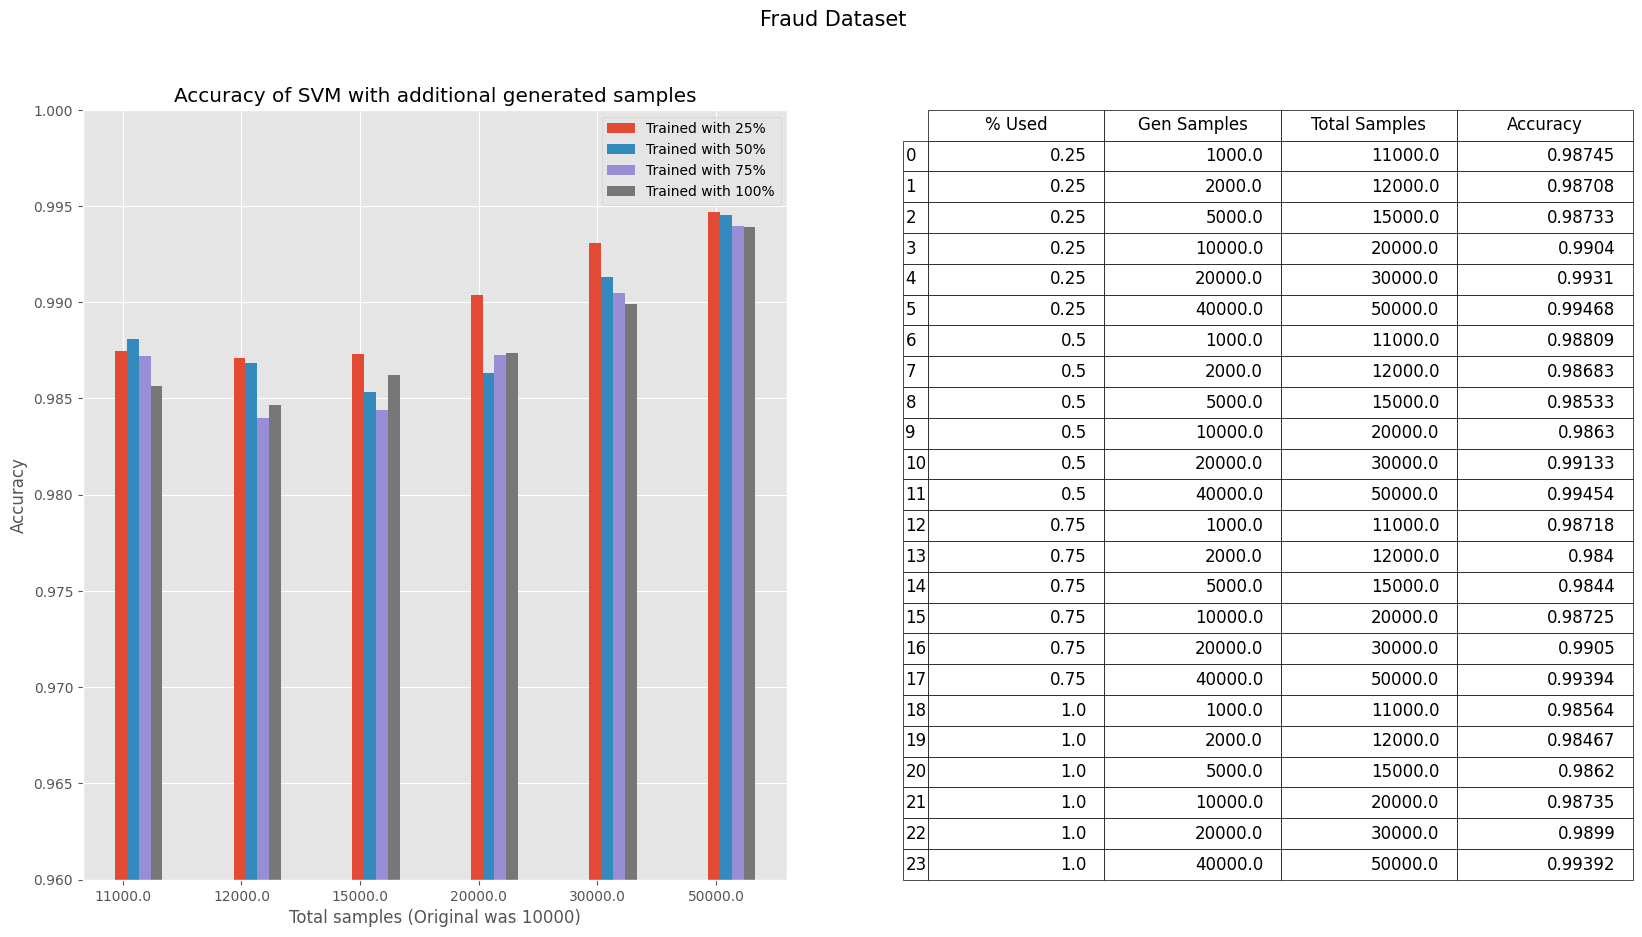

In [62]:
#Visualizing data for the fraud dataset
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,10))
fig.suptitle('Fraud Dataset', fontsize=15)
ax1 = fig.add_subplot(121)

#getting the axes
fraud_categories = np.unique(fraud_acc_added[:,2])
fraud_svm_acc_25 = fraud_acc_added[fraud_acc_added[:,0]==0.25][:,3]
fraud_svm_acc_50 = fraud_acc_added[fraud_acc_added[:,0]==0.50][:,3]
fraud_svm_acc_75 = fraud_acc_added[fraud_acc_added[:,0]==0.75][:,3]

#generating indices for bar groups
bar_width = 0.10
index = np.arange(len(fraud_categories))
#creating the grouped bar chart
ax1.bar(index, fraud_svm_acc_25, bar_width, label='Train 75%, Test 25%')
ax1.bar(index+bar_width, fraud_svm_acc_50, bar_width, label='Train 50%, Test 50%')
ax1.bar(index+(bar_width*2), fraud_svm_acc_75, bar_width, label='Train 75%, Test 25%')
#setting labels and axes
ax1.set_ylim(0.96, 1)
ax1.set_xlabel('Total samples (Original was 10000)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of SVM with additional generated samples')
ax1.set_xticks(index + bar_width / 6, fraud_categories)
ax1.legend()

#setting dataframe next to the graph
ax2 = fig.add_subplot(122)
ax2.axis('off')
table = ax2.table(cellText=fraud_added_df.values, colLabels=fraud_added_df.columns, rowLabels=fraud_added_df.index, bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)

<p>Comments about results for the fraud dataset; note how % used was not really impactful; accuracy increased as samples increased; compare with the base accuracy; note how the accuracy was similar to the baseline but less, probably due to the quality of generated data we saw in the testing above.</p> - Tyler

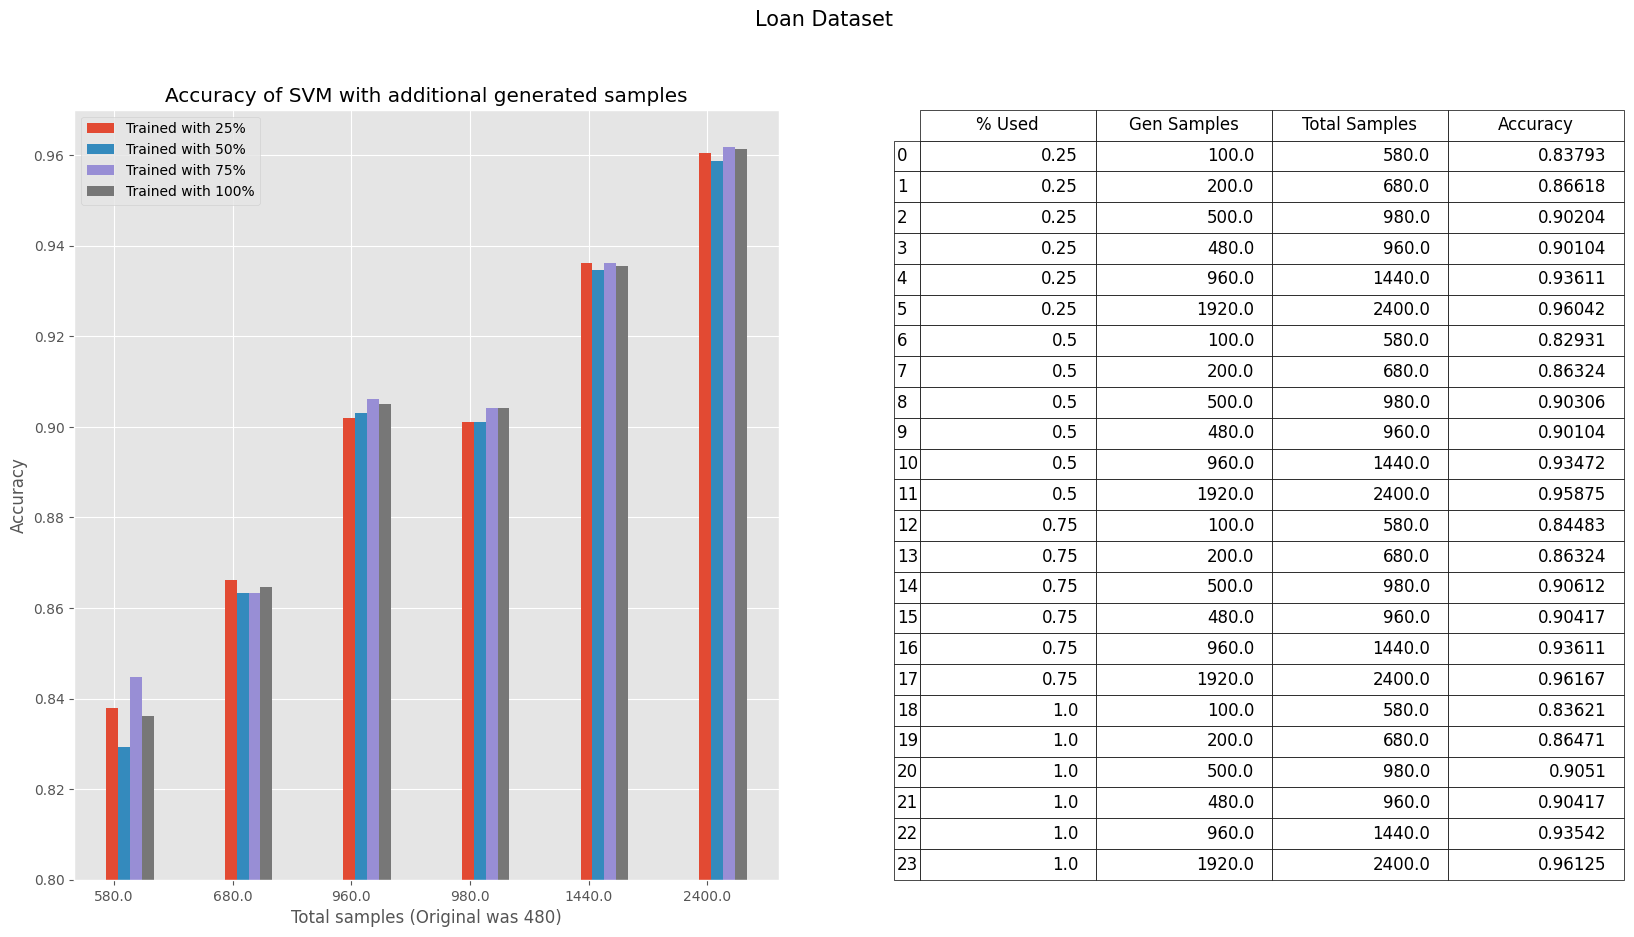

In [65]:
#Visualizing data for the loan dataset
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,10))
fig.suptitle('Loan Dataset', fontsize=15)
ax1 = fig.add_subplot(121)

#getting the axes
loan_categories = np.unique(loan_acc_added[:,2])
loan_svm_acc_25 = loan_acc_added[loan_acc_added[:,0]==0.25][:,3]
loan_svm_acc_50 = loan_acc_added[loan_acc_added[:,0]==0.50][:,3]
loan_svm_acc_75 = loan_acc_added[loan_acc_added[:,0]==0.75][:,3]

#generating indices for bar groups
bar_width = 0.10
index = np.arange(len(loan_categories))
#creating the grouped bar chart
ax1.bar(index, loan_svm_acc_25, bar_width, label='Train 75%, Test 25%')
ax1.bar(index+bar_width, loan_svm_acc_50, bar_width, label='Train 50%, Test 50%')
ax1.bar(index+(bar_width*2), loan_svm_acc_75, bar_width, label='Train 75%, Test 25%')
#setting labels and axes
ax1.set_ylim(0.8,0.97)
ax1.set_xlabel('Total samples (Original was 480)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of SVM with additional generated samples')
ax1.set_xticks(index + bar_width / 6, loan_categories)
ax1.legend()

#setting dataframe next to the graph
ax2 = fig.add_subplot(122)
ax2.axis('off')
table = ax2.table(cellText=loan_added_df.values, colLabels=loan_added_df.columns, rowLabels=loan_added_df.index, bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)

<p>Comments about results for the loan dataset; note how % used was not really impactful; accuracy increased as samples increased; compare with the base accuracy; note how the accuracy increased as samples increased; point out that the generated samples were very impactful in increasing accuracy; increased by 16%, probably due to the quality of data being better</p> - Ash

<hr>

<p>Closing comment about the project, GANs, resources, other remarks; what you learned</p> - Tyler

<h3><u><b>Resources Used</b></u></h3>
<ul>
    <li>https://realpython.com/generative-adversarial-networks/</li>
    <li>https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-gan</li>
    <li>https://medium.com/dida-machine-learning/data-augmentation-with-gans-for-defect-detection-8318fab1a514</li>
    <li>https://www.baeldung.com/cs/ml-gan-data-augmentation</li>
    <li>ChatGPT</li>
    <li>https://www.tensorflow.org/tutorials/generative/dcgan</li>
<ul>